In [447]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [448]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [449]:
import example_systems

pendulum_system_gt = example_systems.double_pendulum

In [450]:
from helpers import vec

timesteps = np.arange(0.0, 3.0, step=pendulum_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 6, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 3, 1))

# initial position and velocity
states_gt[0] = vec(
    0,      # cart
    0,      # theta_1
    np.pi/2,    # theta_2
    0,      # cart_vel
    0,      # theta_1_vel
    0       # theta_2_vel
)

# cart acceleration schedule
controls[:] = vec(0.0)

w_test = np.zeros((6, 1))

for t in tqdm(range(1, T)):
# for t in range(1, T):
    x = states_gt[t-1]
    u = controls[t]

    x_next = pendulum_system_gt.query_dynamics_model(x, u, w_test)

    # DEBUG
    x_next = x_next.at[0].set(0)
    x_next = x_next.at[1].set(0)
    x_next = x_next.at[3].set(0)
    x_next = x_next.at[4].set(0)

    states_gt[t] = x_next

    # print("theta_2:", x_next[4])

    z = pendulum_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 2999/2999 [00:49<00:00, 60.49it/s]


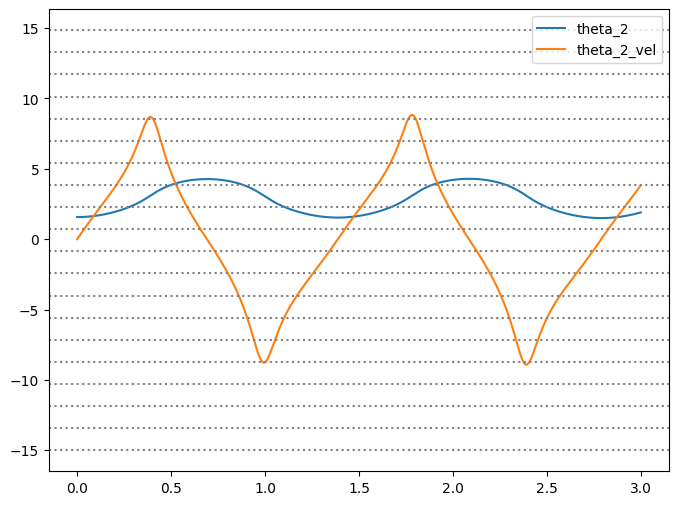

In [451]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,4,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

theta_2_gt = states_gt[:t_max,2,0]
theta_2_vel_gt = states_gt[:t_max,5,0]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(timesteps[:t_max], theta_2_gt, label="theta_2")
ax.plot(timesteps[:t_max], theta_2_vel_gt, label="theta_2_vel")
for y in np.arange(-15, 15, step=np.pi/2):
    ax.axhline(y, 0, timesteps[t_max], linestyle=":", color="gray")

ax.legend()

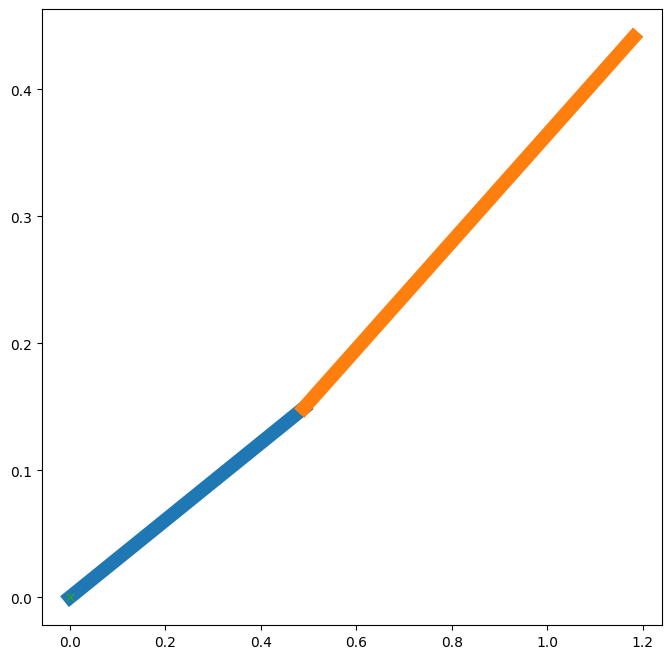

In [465]:
def visualize_pendulum(ax, cart, theta_1, theta_2, L1, L2):
    cart_pos = vec(cart, 0)
    link1_pos = cart_pos + vec(L1*np.cos(theta_1), L2*np.sin(theta_1))
    link2_pos = link1_pos + vec(L2*np.cos(theta_2), L2*np.sin(theta_2))

    ax.plot([cart_pos[0], link1_pos[0]], [cart_pos[1], link1_pos[1]], linewidth=10)
    ax.plot([link1_pos[0], link2_pos[0]], [link1_pos[1], link2_pos[1]], linewidth=10)
    ax.plot(*cart_pos, marker="x")


fig, ax = plt.subplots(figsize=(8, 8))
visualize_pendulum(ax, 0.0, 0.2, 0.4, 0.5, 0.75)